------------------------------------------------------------
## EECE276 전자전기공학실험
### Lab5. 딥러닝을 이용한 영상인식  

###### *Department of Electrical Engineering*
###### *Intelligent Control and System Lab*
###### *written by hyeyeon Choi, 2020.10.07 (hyeyeon@postech.ac.kr)*
------------------------------------------------------------

#### 1. tensorflow 버전 확인 및 1.15 버전 설치

In [1]:
import tensorflow as tf

tf.__version__

'2.3.0'

In [2]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.3.0


In [3]:
!pip install tensorflow==1.15 # 1.15 버전 Tensorflow 설치

     |████████████████████████████████| 412.3MB 23kB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 3.8MB 39.4MB/s 
     |████████████████████████████████| 512kB 38.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=4ae7403db5674e1341a63d1bad5e490682a6f7016f6c3be08f55beba0a3ea61d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [1]:
import tensorflow as tf

tf.__version__

'1.15.0'

#### 2. 실험 가이드 코드 (mnist example)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import cv2
from cv2 import resize as imresize
from google.colab import files
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [3]:
print ('Shape of the training \nImage:', mnist.train.images.shape, '\nlabel:', mnist.train.labels.shape )
print ('\nShape of the test \nImage:', mnist.test.images.shape, '\nlabel:', mnist.test.labels.shape )

Shape of the training 
Image: (55000, 784) 
label: (55000, 10)

Shape of the test 
Image: (10000, 784) 
label: (10000, 10)


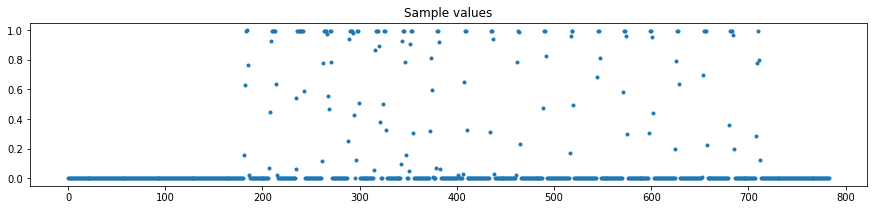

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


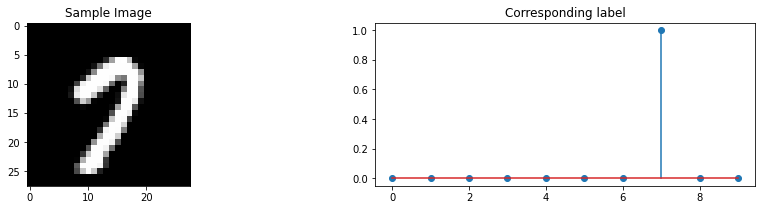

In [4]:
idx = np.random.randint(len(mnist.train.images))

plt.figure(figsize=(15,3))
plt.plot(mnist.train.images[idx],'o', markersize=3)
plt.title('Sample values')
plt.show()

plt.figure(figsize=(15,3))
plt.subplot(1,2,1); plt.imshow(mnist.train.images[idx].reshape(28,28), cmap=plt.cm.gray)
plt.title('Sample Image')
plt.subplot(1,2,2); plt.stem(mnist.train.labels[idx])
plt.title('Corresponding label')
plt.show()

In [5]:
# Define Network
# 딥 러닝 모델에서 사용되는 weight parameter(weights, biases)를 미리 선언합니다. 
weights = {
    'conv1' : tf.Variable (tf.random_normal([3,3,1,32], stddev = 0.1)),
    'conv2' : tf.Variable (tf.random_normal([3,3,32,64], stddev = 0.1)),
    'fc' : tf.Variable(tf.random_normal([7 * 7 * 64, 10]))
}
biases = {
    'bias1' : tf.Variable(tf.random_normal([32], stddev = 0.1)),
    'bias2' : tf.Variable(tf.random_normal([64], stddev = 0.1)), 
    'bias3' : tf.Variable(tf.random_normal([10], stddev = 0.1)),
}

def build_model(input_x, weights, biases):
    Conv1 = tf.nn.conv2d(input_x, weights['conv1'], strides=[1,1,1,1], padding='SAME') 
    Conv1 = tf.add(Conv1, biases['bias1'])
    Conv1 = tf.nn.relu(Conv1)
    PooL1 = tf.nn.max_pool(Conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
    
    Conv2 = tf.nn.conv2d(PooL1, weights['conv2'], strides=[1,1,1,1], padding='SAME') 
    Conv2 = tf.add(Conv2, biases['bias2'])
    Conv2 = tf.nn.relu(Conv2)
    PooL2 = tf.nn.max_pool(Conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
    
    hidden = tf.reshape(PooL2, [-1,7 * 7 * 64])
    output = tf.add(tf.matmul(hidden, weights['fc']), biases['bias3'])
    return output

In [6]:
num_class = 10
H, W, C = 28,28,1

x = tf.placeholder(tf.float32, [None,784]) 
x_img = tf.reshape(x, [-1, H, W, C])
y = tf.placeholder(tf.float32, [None,num_class]) 

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Learning started. It takes sometimes.
Epoch: 0001 ,cost = 2.672592820
Epoch: 0002 ,cost = 0.582474355
Epoch: 0003 ,cost = 0.400956521
Epoch: 0004 ,cost = 0.317694575
Epoch: 0005 ,cost = 0.268456962
Epoch: 0006 ,cost = 0.232185005
Epoch: 0007 ,cost = 0.205819518
Epoch: 0008 ,cost = 0.183882632
Epoch: 0009 ,cost = 0.166464635
Epoch: 0010 ,cost = 0.151511978
Epoch: 0011 ,cost = 0.139510774
Epoch: 0012 ,cost = 0.129309756
Epoch: 0013 ,cost = 0.119899631
Epoch: 0014 ,cost = 0.111914413
Epoch: 0015 ,cost = 0.105985341
Learning Finished!


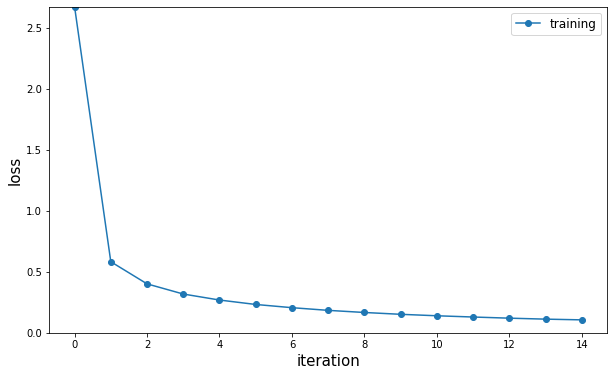

In [7]:
# Define Loss
pred = build_model(x_img, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y)
loss = tf.reduce_mean(loss)

LR = 0.0001    # learning rate
optimizer = tf.train.AdamOptimizer(LR).minimize(loss)

# init
sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_epochs = 15
batch_size = 100

loss_record = []
# train
print('Learning started. It takes sometimes.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {x: batch_xs, y: batch_ys}
        c, _, = sess.run([loss,optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
    print("Epoch:","%04d"%(epoch + 1),",cost =","{:.9f}".format(avg_cost))
    loss_record.append(avg_cost)
print('Learning Finished!')
 
plt.figure(figsize=(10,6))
plt.plot(loss_record, 'o-', label = 'training')

plt.xlabel('iteration', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record)])
plt.show()

In [9]:
# Test
test_x, test_y = mnist.test.next_batch(100)
my_pred = sess.run(pred, feed_dict = {x : test_x})
my_pred = np.argmax(my_pred, axis = 1)

labels = np.argmax(test_y, axis = 1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}%".format(accr*100))

Accuracy : 99.0%


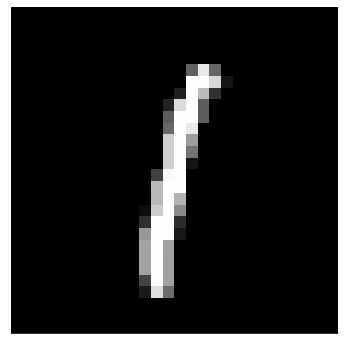

Prediction : 1
Probability : [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]


In [10]:
test_x, test_y = mnist.test.next_batch(1)
logits = sess.run(tf.nn.softmax(pred), feed_dict = {x : test_x})
predict = np.argmax(logits)

plt.figure(figsize = (6,6))
plt.imshow(test_x.reshape(28,28), 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

print('Prediction : {}'.format(predict))
np.set_printoptions(precision = 2, suppress = True)
print('Probability : {}'.format(logits.ravel()))

#### 3. (Problem 1) 자신의 학번 뒷자리 4개를 인식

In [11]:
# 파일 업로드 (자신의 손 글씨 영상을 업로드)
uploaded = files.upload()

Saving b.jpg to b.jpg


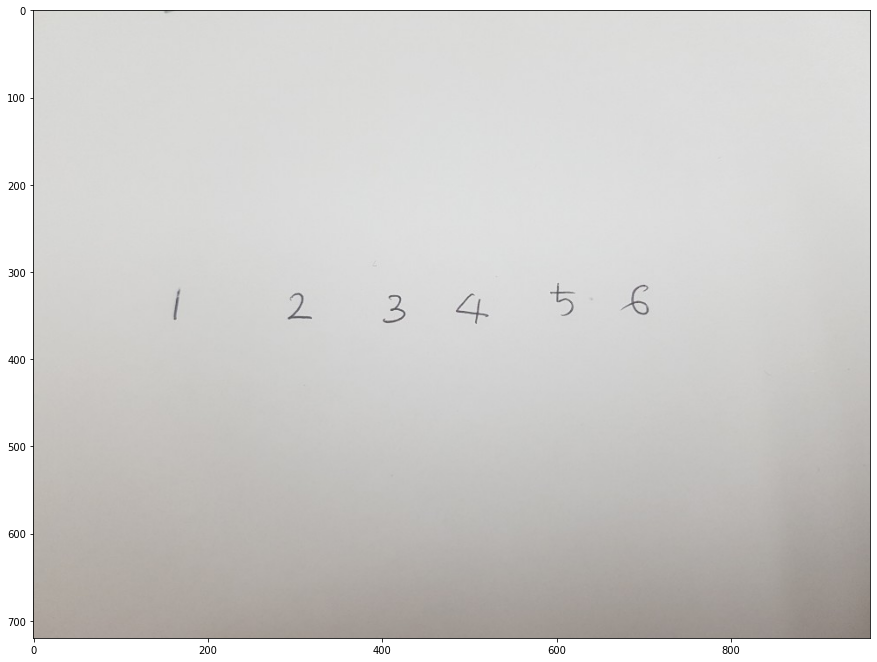

In [12]:
sample = imageio.imread('b.jpg')
plt.figure(figsize=(15,15))
plt.imshow(sample); plt.show()

- 아래 코드는 손 글씨 영상에서 숫자 하나하나를 추출하고 시각화하는 코드입니다 
- 예시) sample 영상에서 숫자 '1' 영역을 추출: 
  - number1 = sample[ y1 좌표: y2 좌표 , x1좌표 : x2 좌표 , : ]  
  - 이때, sample 영상에서 숫자 '1' 영역에 해당하는 좌표는 위의 sample 영상에서 보고 적당히 지정하여 줍니다. 
    - (y1, y2, x1, x2) = (310, 360, 140, 190) 


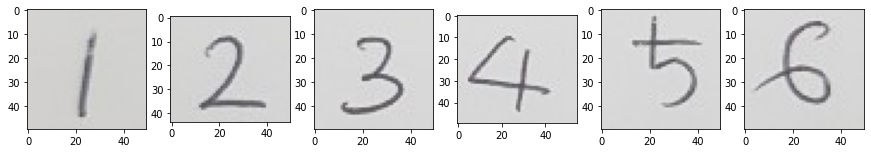

In [13]:
plt.figure(figsize=(15,4))
plt.subplot(1,6,1); plt.imshow(sample[310:360,140:190,:]); n1 = sample[310:360,140:190,:]
plt.subplot(1,6,2); plt.imshow(sample[316:360,280:330,:]); n2 = sample[316:360,280:330,:]
plt.subplot(1,6,3); plt.imshow(sample[315:365,390:440,:]); n3 = sample[315:365,390:440,:]
plt.subplot(1,6,4); plt.imshow(sample[315:365,480:535,:]); n4 = sample[315:365,480:535,:]
plt.subplot(1,6,5); plt.imshow(sample[310:360,580:630,:]); n5 = sample[310:360,580:630,:]
plt.subplot(1,6,6); plt.imshow(sample[310:360,670:720,:]); n6 = sample[310:360,670:720,:]; plt.show()

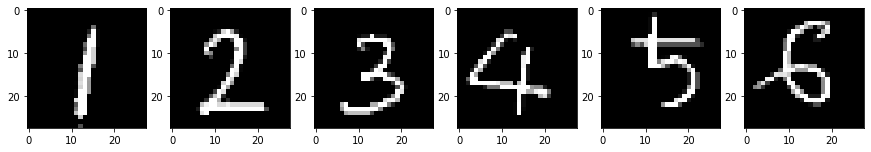

In [14]:
my_img = []
plt.figure(figsize=(15,4))
for idx, im in enumerate ([n1,n2,n3,n4,n5,n6]):
    im =255*(im[:,:,0] < 200).astype('float32')
    im = imresize(im, (28,28))
    im = im/255
    my_img.append(im)
    plt.subplot(1,6,idx+1); plt.imshow(im,'gray'); 
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


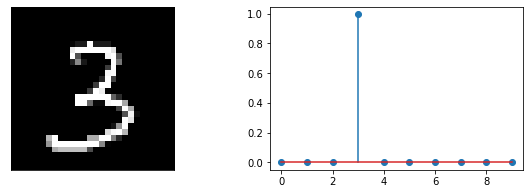

Prediction : 3
Probability : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [18]:
idx = 2
logits = sess.run(tf.nn.softmax(pred), feed_dict = {x : my_img[idx].reshape(1,784)})
predict = np.argmax(logits)

plt.figure(figsize = (10,3))
plt.subplot(1,2,1); plt.imshow(my_img[idx].reshape(28,28), 'gray')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2); plt.stem(logits.ravel())
plt.show()
print('Prediction : {}'.format(predict))
np.set_printoptions(precision = 2, suppress = True)
print('Probability : {}'.format(logits.ravel()))